# 4.3. Combinando Flats

Hay un paso en la combinación de pisos que es diferente de la mayoría de las otras combinaciones de imágenes: los pisos deben escalarse a un valor común antes de combinarlos. Esto es particularmente importante si los planos son planos crepusculares en los que el valor medio de la imagen suele cambiar significativamente a medida que se toman las imágenes.

Los pisos normalmente se agrupan por filtro al combinarlos. Es decir, se produce un plano combinado para cada filtro en el que se tomaron planos.

Se hará combinación para cada uno de los dos ejemplos del cuaderno anterior.

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import ccdproc as ccdp
from astropy.stats import mad_std
from astropy.visualization import hist

from convenience_functions import show_image

In [3]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

# 4.3.1. Ejemplo 1 
Comenzamos configurando una colección de imágenes para los datos reducidos. Estos datos provienen del chip 0 de la cámara de gran formato enfriada criogénicamente en el Observatorio Palomar.

In [4]:
calibrated_path = Path('example1-reduced')

flat_imagetyp = 'flatfield'

ifc = ccdp.ImageFileCollection(calibrated_path)

In [5]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

{"g'", "i'"}

Estos planos son planos de cúpula, esencialmente imágenes de una pantalla en la cúpula iluminada por una fuente de luz, por lo que no esperaría que haya mucha variación en el valor de píxel típico entre diferentes exposiciones. Sin embargo, normalmente hay alguna variación, por lo que la graficamos a continuación.

[20173.0, 20169.0, 20156.666666666668, 21026.0, 21042.333333333332, 21058.0]


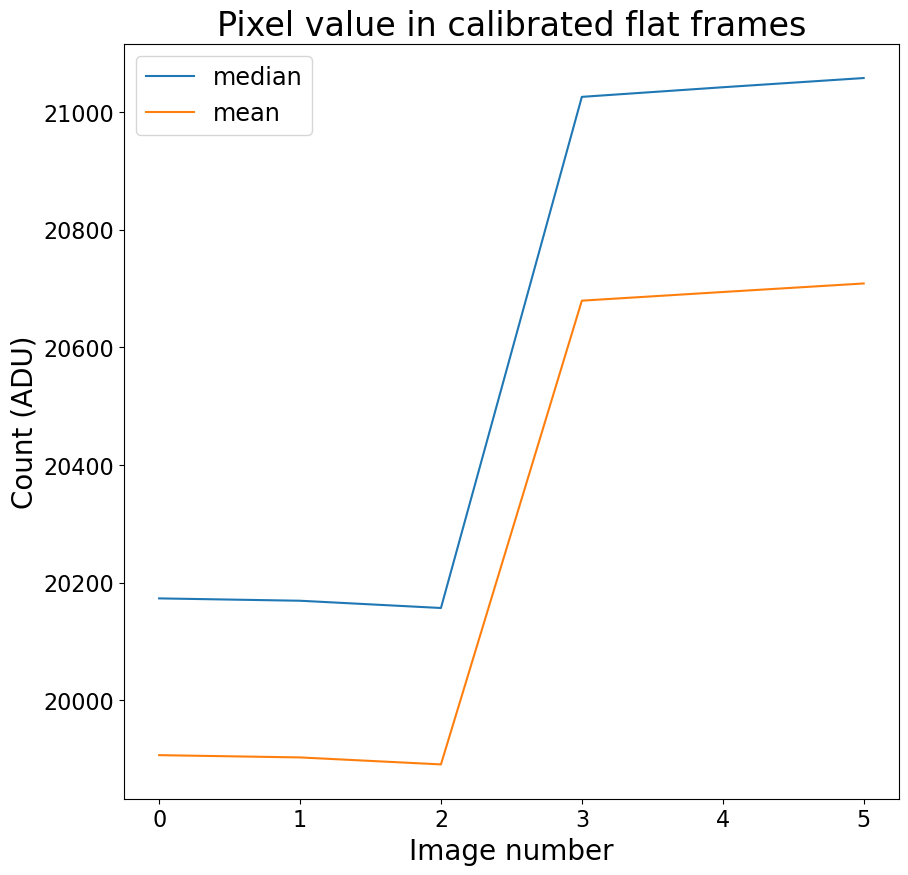

In [6]:
median_count = [np.median(data) for data in ifc.data(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in ifc.data(imagetyp=flat_imagetyp)]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

Aunque se trata de una variación de fotograma a fotograma menor que la que veremos en el ejemplo 2, es de aproximadamente un 5 %. Si tuviéramos que combinarlos sin escalar los planos a un valor común, las imágenes con recuentos más altos tendrían efectivamente más peso que las imágenes.

Hay una diferencia sustancial entre la media y la mediana de estos datos. Por lo general, es mejor usar la mediana porque los valores extremos no afectan tanto a la mediana como a la media.

Para escalar los marcos para que tengan el mismo valor mediano, necesitamos definir una función que pueda calcular el inverso de la mediana dados los datos.



In [7]:
def inv_median(a):
    return 1 / np.median(a)

In [8]:
for filt in flat_filters:
    to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    dark_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_path / dark_file_name)

INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


INFO:astropy:splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 4 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# 4.3.1.1. Discusión del Ejemplo 1 

Comenzaremos comprobando que se ha creado el número correcto de flats combinados. Había dos filtros, g'y i'en los datos sin procesar, debería haber dos planos combinados. Necesitamos actualizar los ImageFileCollectiondatos reducidos porque se les han agregado nuevos archivos, nuestros flats.

In [12]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(["combined_flat_filter_g'.fit", "combined_flat_filter_i'.fit"],
      dtype='<U27')

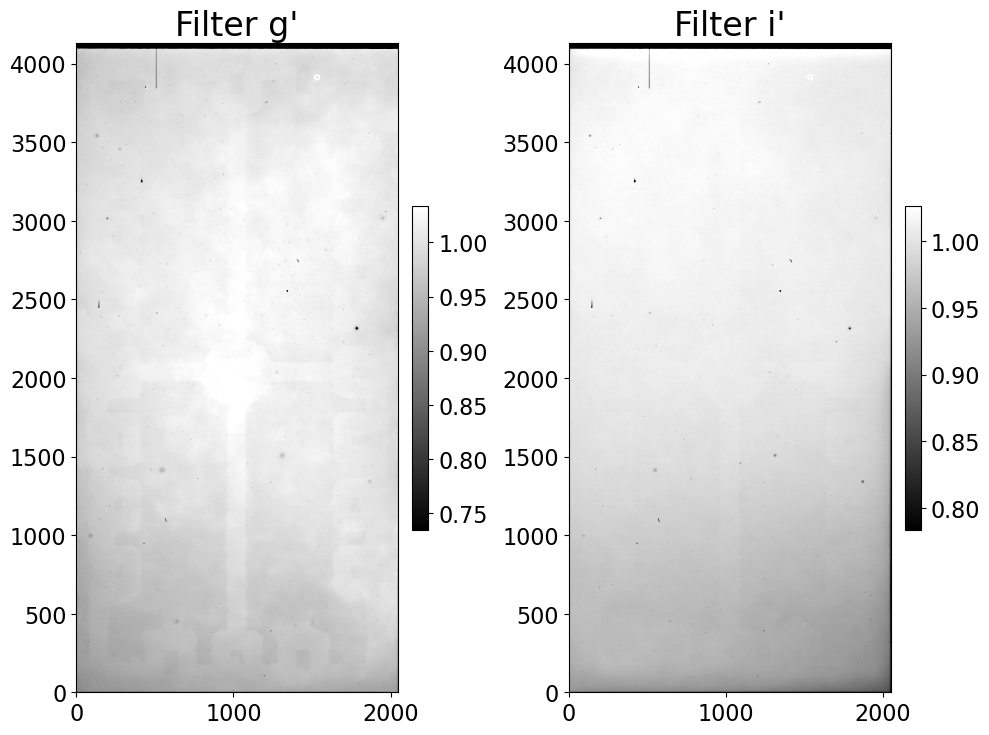

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20), tight_layout=True)

for ccd, axis in zip(ifc.ccds(imagetyp=flat_imagetyp, combined=True), axes):
    show_image(ccd.data, cmap='gray', fig=fig, ax=axis)
    title = "Filter {}".format(ccd.header['filter'])
    axis.set_title(title)

Lo primero que hay que notar es que los bemoles son diferentes en estos dos filtros. Eso es de esperar porque uno de los elementos en el camino óptico, el filtro, es diferente.

El patrón de la electrónica en las imágenes planas se debe a que se trata de un CCD con iluminación posterior. Los píxeles de detección de luz están en la parte inferior del chip y la luz debe atravesar el chip para llegar al sensor. Los pequeños puntos oscuros son lugares donde el chip no se adelgazó de manera uniforme.

Compare esto con el Ejemplo 2 a continuación, que muestra un plano tomado con una cámara con iluminación frontal.

# 4.3.2. Ejemplo 2 
Los datos de este ejemplo son de un Andor Aspen CG16M refrigerado termoeléctricamente. Estos planos son planos crepusculares, tomados justo después del atardecer.

In [14]:
calibrated_path = Path('example2-reduced')

flat_imagetyp = 'flat'

ifc = ccdp.ImageFileCollection(calibrated_path)

In [15]:
flat_filters = set(h['filter'] for h in ifc.headers(imagetyp=flat_imagetyp))
flat_filters

{'r'}

[45891.90222222222, 44225.99888888889, 43128.94777777778, 41495.89333333333, 39871.95111111111, 39019.864, 38817.97997777778, 38863.88776666667, 38822.93813333334, 38661.95832222222]


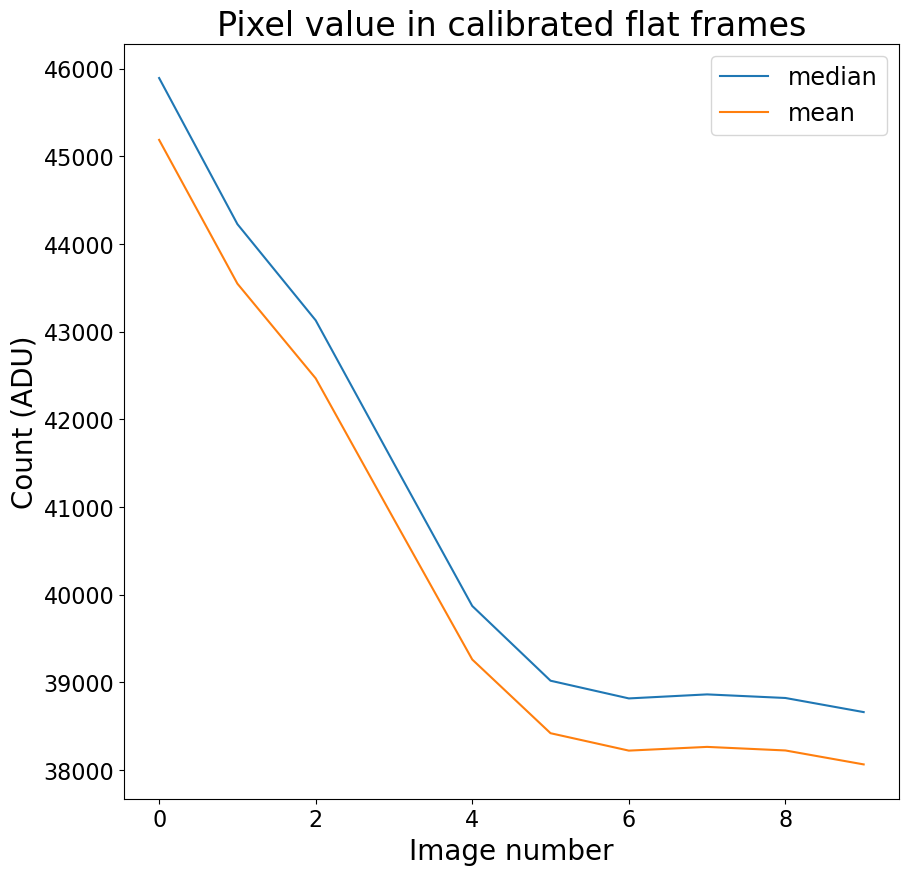

In [16]:
median_count = [np.median(hdu.data) for hdu in ifc.hdus(imagetyp=flat_imagetyp)]
mean_count = [np.mean(data) for data in ifc.data(imagetyp=flat_imagetyp)]
plt.plot(median_count, label='median')
plt.plot(mean_count, label='mean')
plt.xlabel('Image number')
plt.ylabel('Count (ADU)')
plt.title('Pixel value in calibrated flat frames')
plt.legend()
print(median_count)

In [17]:
def inv_median(a):
    return 1 / np.median(a)

for filt in flat_filters:
    to_combine = ifc.files_filtered(imagetyp=flat_imagetyp, filter=filt, include_path=True)
    combined_flat = ccdp.combine(to_combine,
                                 method='average', scale=inv_median,
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std,
                                 mem_limit=350e6
                                )

    combined_flat.meta['combined'] = True
    dark_file_name = 'combined_flat_filter_{}.fit'.format(filt.replace("''", "p"))
    combined_flat.write(calibrated_path / dark_file_name)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
INFO:astropy:splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 22 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


# 4.3.2.1. Discusión del Ejemplo 2 
Esperamos solo un piso combinado porque solo había un filtro. Se ImageFileCollectionactualiza antes de que lo consultemos porque los pisos combinados se agregaron después de que se creó la colección.



In [18]:
ifc.refresh()
ifc.files_filtered(imagetyp=flat_imagetyp, combined=True)

array(['combined_flat_filter_r.fit'], dtype='<U31')

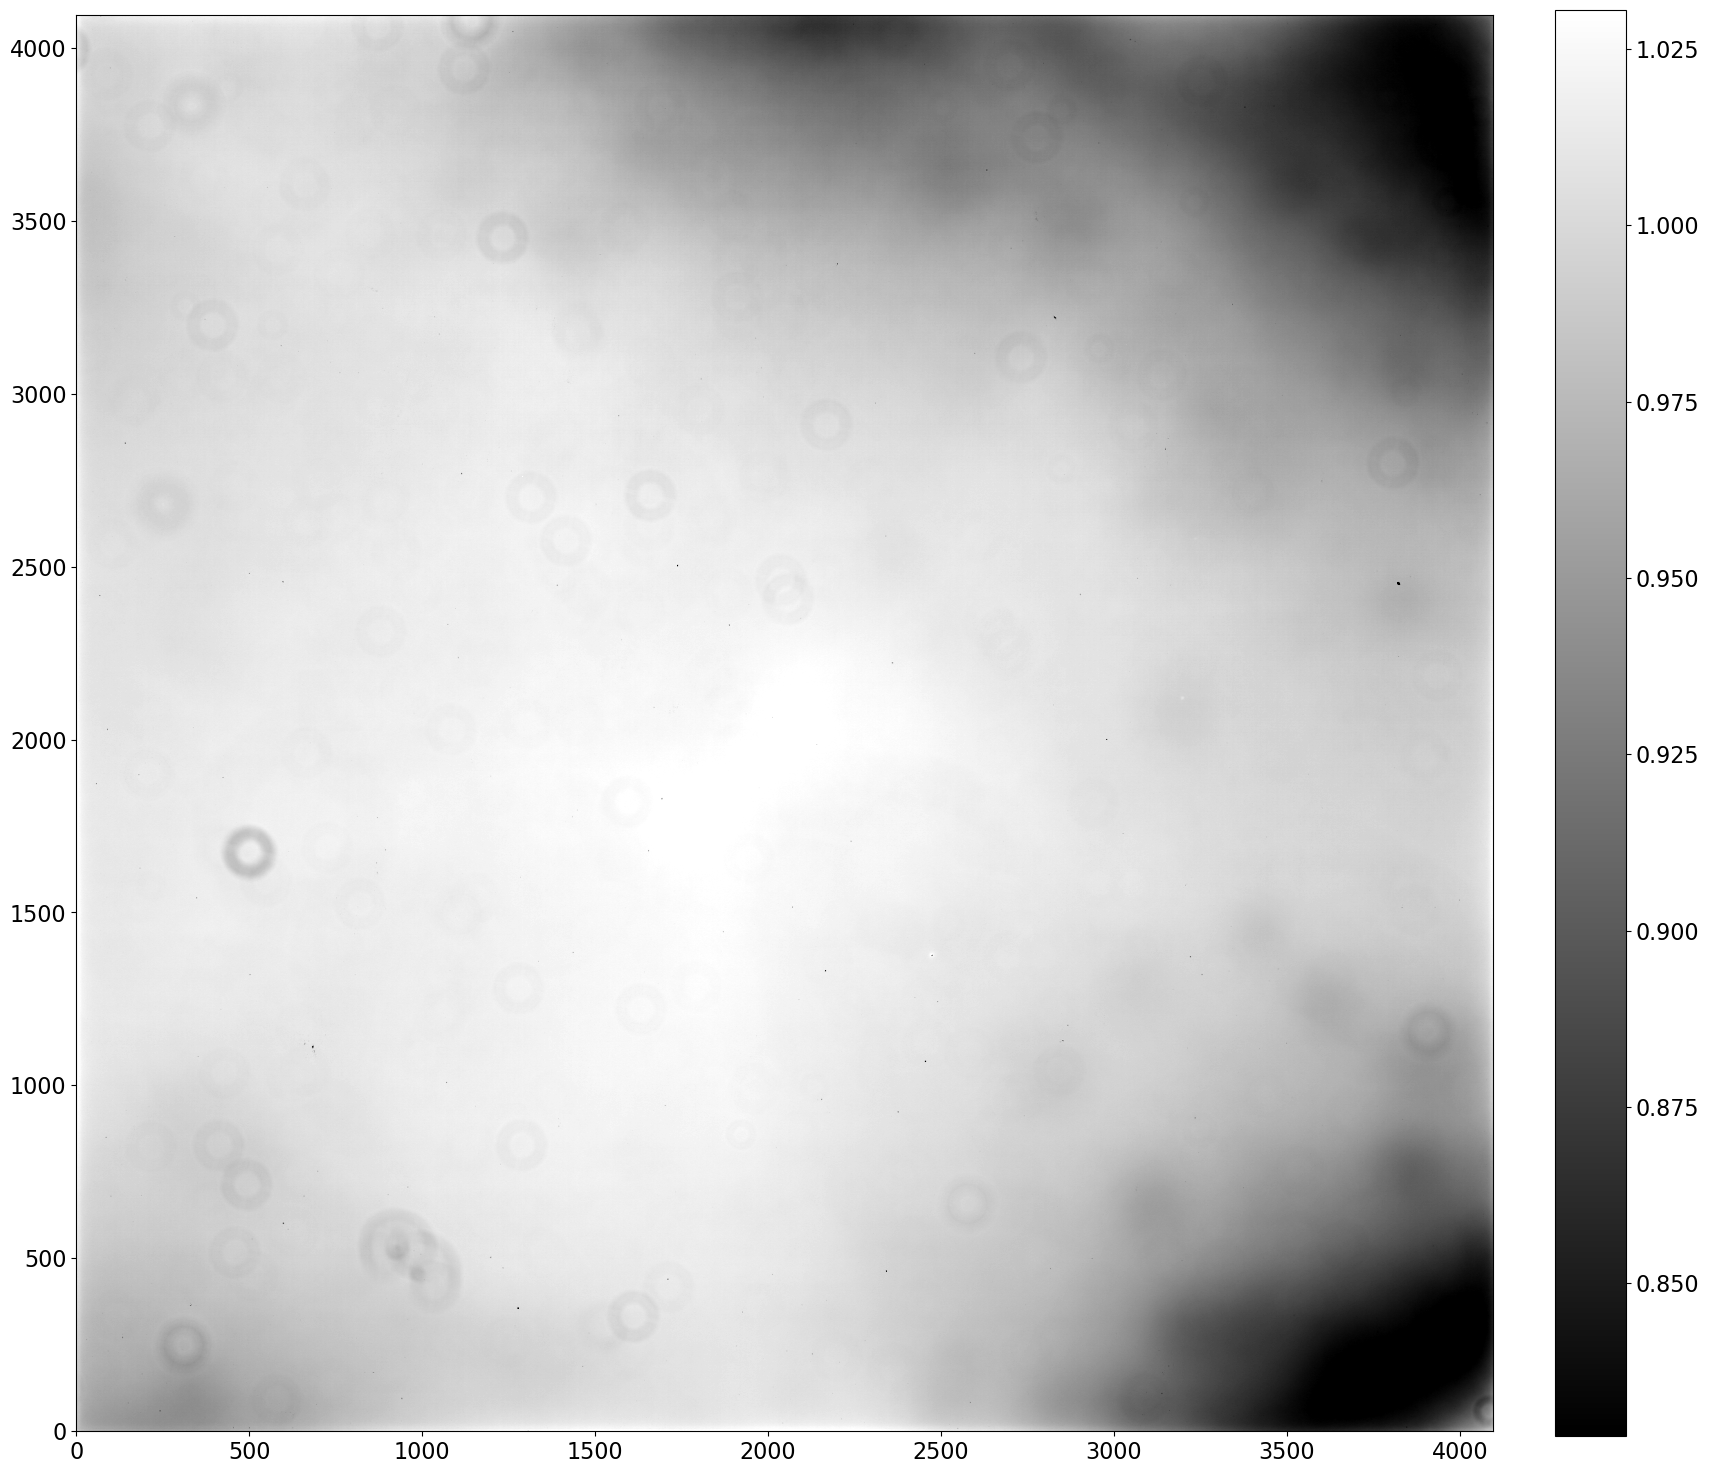

In [19]:
show_image(combined_flat, cmap='gray', figsize=(10, 20))

Este plano se ve muy diferente al del Ejemplo 1 porque este CCD está iluminado por la parte frontal y el anterior está iluminado por la parte posterior. Eso significa que el sensor está en la parte superior del chip y la luz no pasa a través del chip del sensor para llegar a los sensores. Aunque aquí solo se muestra un filtro, el campo plano se ve ligeramente diferente a través de otros filtros en esta cámara.